<a href="https://colab.research.google.com/github/batu-el/understanding-inductive-biases-of-gnns/blob/main/notebooks/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install torch torchdata torch_geometric dgl

# Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch Geometric")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries")
    !pip install networkx
    !pip install lovely-tensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 106.2 MB/s eta 0:00:00
Installing PyTorch Geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 64.6 MB/s eta 0:00:00
Installing other libraries
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.9 MB/s eta 0:00:00


In [2]:
import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, LayerNorm, Module, ModuleList, Sequential
from torch.nn import TransformerEncoder, TransformerEncoderLayer, MultiheadAttention
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, dense_to_sparse, to_dense_batch, to_dense_adj

from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

# from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import lovely_tensors as lt
lt.monkey_patch()

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


All imports succeeded.
Python version 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version 2.5.1+cu121
PyG version 2.6.1


In [3]:
# Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


# Datasets

In [4]:
from torch_geometric.datasets import WebKB, WikipediaNetwork

DATASETS = {}

# Chamelion & Squirrel
# Cora & Citeseer
# Cornell & Texas & Wisconsin

## Mid Size Datasets
# Citation Networks
dataset = 'Cora'
dataset = Planetoid('/tmp/Cora', dataset)
data = dataset[0]
DATASETS['Cora'] = data
dataset = 'Citeseer'
dataset = Planetoid('/tmp/Citeseer', dataset)
data = dataset[0]
DATASETS['Citeseer'] = data
# Wikipedia Pages
dataset = 'Chameleon'
dataset = WikipediaNetwork(root='/tmp/Chameleon', name='Chameleon')
data = dataset[0]
DATASETS['Chameleon'] = data
dataset = 'Squirrel'
dataset = WikipediaNetwork(root='/tmp/Squirrel', name='Squirrel')
data = dataset[0]
DATASETS['Squirrel'] = data
### Small Sized Datasets
# Web Pages
dataset = WebKB(root='/tmp/Wisconsin', name='Wisconsin')
data = dataset[0]
DATASETS['Wisconsin'] = data
dataset = WebKB(root='/tmp/Cornell', name='Cornell')
data = dataset[0]
DATASETS['Cornell'] = data
dataset = WebKB(root='/tmp/Texas', name='Texas')
data = dataset[0]
DATASETS['Texas'] = data

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# import tqdm
# ### Shortest Paths ###
# def get_shortest_path_matrix(adjacency_matrix):
#     graph = nx.from_numpy_array(adjacency_matrix.cpu().numpy(), create_using=nx.DiGraph)
#     shortest_path_matrix = nx.floyd_warshall_numpy(graph)
#     shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
#     return shortest_path_matrix

# SHORTEST_PATHS = {}
# for data_key in tqdm.tqdm(DATASETS):
#   print(data_key)
#   data = DATASETS[data_key]
#   dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
#   dense_shortest_path_matrix = get_shortest_path_matrix(dense_adj)
#   SHORTEST_PATHS[data_key] = dense_shortest_path_matrix

# ### Save the Shortest Paths
# import pickle
# with open('sp_dict.pkl', 'wb') as f:
#     pickle.dump(SHORTEST_PATHS, f)
import pickle
with open('drive/MyDrive/Colab Notebooks/L65/shortest_paths/sp_dict.pkl', 'rb') as f:
# with open('drive/MyDrive/L65/shortest_paths/sp_dict.pkl', 'rb') as f:
    SHORTEST_PATHS = pickle.load(f)

In [8]:
for data_key in DATASETS:
  data = DATASETS[data_key]
  data.dense_sp_matrix = SHORTEST_PATHS[data_key]
  data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
  data.dense_adj = data.dense_adj.cuda() + torch.eye(data.dense_adj.shape[0]).cuda()
  data.dense_adj[data.dense_adj == 2] = 1
  data = T.AddLaplacianEigenvectorPE(k = 16, attr_name = 'pos_enc')(data)
  DATASETS[data_key] = data

In [9]:
### Masks ###

def generate_masks(num_nodes=None,num_runs=None,train_ratio=None, val_ratio=None):
    masks = { 'train_mask': np.zeros((num_nodes, num_runs), dtype=int),
              'val_mask': np.zeros((num_nodes, num_runs), dtype=int),
              'test_mask': np.zeros((num_nodes, num_runs), dtype=int)}

    for run in range(num_runs):
        indices = np.arange(num_nodes)
        np.random.shuffle(indices)
        train_end = int(train_ratio * num_nodes)
        val_end = train_end + int(val_ratio * num_nodes)
        masks['train_mask'][indices[:train_end], run] = 1
        masks['val_mask'][indices[train_end:val_end], run] = 1
        masks['test_mask'][indices[val_end:], run] = 1

    tensor_masks = {'train_mask': torch.tensor(masks['train_mask']),
                    'val_mask':torch.tensor(masks['val_mask']),
                    'test_mask':torch.tensor(masks['test_mask'])}
    return tensor_masks

for data_key in DATASETS:
    data = DATASETS[data_key]

    masks = generate_masks(num_nodes=data.x.shape[0], num_runs=10, train_ratio=0.4, val_ratio=0.3)
    data.train_mask = masks['train_mask'].bool()
    data.val_mask = masks['val_mask'].bool()
    data.test_mask = masks['test_mask'].bool()

    if len(data.train_mask.shape)==1:
      print('Add 10 Masks')
    else:
      print('We have 10 Masks')
      print('Train Ratio:',(data.train_mask[:,0].sum() / len(data.train_mask[:,0])).item())
      print('Val Ratio:',(data.val_mask[:,0].sum() / len(data.val_mask[:,0])).item())
      print('Test Ratio:',(data.test_mask[:,0].sum() / len(data.test_mask[:,0])).item())

We have 10 Masks
Train Ratio: 0.39992615580558777
Val Ratio: 0.29985228180885315
Test Ratio: 0.3002215623855591
We have 10 Masks
Train Ratio: 0.39975953102111816
Val Ratio: 0.29996994137763977
Test Ratio: 0.30027052760124207
We have 10 Masks
Train Ratio: 0.39964866638183594
Val Ratio: 0.2999560832977295
Test Ratio: 0.30039525032043457
We have 10 Masks
Train Ratio: 0.39992308616638184
Val Ratio: 0.2999423146247864
Test Ratio: 0.3001345992088318
We have 10 Masks
Train Ratio: 0.39840638637542725
Val Ratio: 0.29880478978157043
Test Ratio: 0.3027888536453247
We have 10 Masks
Train Ratio: 0.3989070951938629
Val Ratio: 0.2950819730758667
Test Ratio: 0.3060109317302704
We have 10 Masks
Train Ratio: 0.3989070951938629
Val Ratio: 0.2950819730758667
Test Ratio: 0.3060109317302704


## Table 1: Dataset Statistics

In [11]:
### Table 1 ###
### Dataset Statistics ###
# import dgl
# Homophily_Levels = {}

# for data_key in DATASETS:
#   data = DATASETS[data_key]
#   edge_index_tensor = torch.tensor(data.edge_index.cpu().numpy(), dtype=torch.long)
#   g = dgl.graph((edge_index_tensor[0], edge_index_tensor[1]), num_nodes=data.x.shape[0])
#   g.ndata['y'] = torch.tensor(data.y.cpu().numpy(), dtype=torch.long)
#   Homophily_Levels[data_key] = {'Node Homophily':dgl.node_homophily(g, g.ndata['y'])*100,
#                                 'Edge Homophily':dgl.edge_homophily(g, g.ndata['y'])*100,
#                                 'Adjusted Homophily':dgl.adjusted_homophily(g, g.ndata['y'])*100,
#                                 'Number of Nodes': int(g.num_nodes()),
#                                 'Number of Edges': int(g.num_edges())
#                                 }
# df = pd.DataFrame(Homophily_Levels).round(1)
# df

# Cache Data

In [12]:
drive_path = 'drive/MyDrive/Colab Notebooks/L65/' #replace with the directory of the trained models

In [13]:
import pickle

NUM_LAYERS = 1
NUM_HEADS = 1
# with open('drive/MyDrive/Colab Notebooks/L65_Project/' + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
with open(drive_path + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
  all_stats_1L_1H = pickle.load(f)

In [14]:
NUM_LAYERS = 1
NUM_HEADS = 2
# with open('drive/MyDrive/Colab Notebooks/L65_Project/' + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
with open(drive_path + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
  all_stats_1L_2H = pickle.load(f)

In [15]:
NUM_LAYERS = 2
NUM_HEADS = 1
with open(drive_path + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
# with open(my_path + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
  all_stats_2L_1H = pickle.load(f)

In [16]:
NUM_LAYERS = 2
NUM_HEADS = 2
with open(drive_path + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
# with open(my_path + f'all_stats_{NUM_LAYERS}L_{NUM_HEADS}H.pkl', 'rb') as f:
  all_stats_2L_2H = pickle.load(f)

In [17]:
def get_attns(all_stats):
    all_attns = {}

    for data_key in all_stats:
        st_avg_attentions = []
        dt_avg_attentions = []
        dt2_avg_attentions = []
        run_stats = all_stats[data_key]
        for run_idx in run_stats:
            attentions = run_stats[run_idx]['attentions']
            st_avg_attentions.append(attentions['SparseGraphTransformerModel'])
            dt_avg_attentions.append(attentions['DenseGraphTransformerModel'])
            dt2_avg_attentions.append(attentions['DenseGraphTransformerModel_V2'])
        st_attentions = torch.stack(st_avg_attentions)
        dt_attentions = torch.stack(dt_avg_attentions)
        dt2_attentions = torch.stack(dt2_avg_attentions)
        all_attns[data_key] = {'st_avg': st_attentions.mean(axis=0),
                              'dt_avg': dt_attentions.mean(axis=0),
                              'dt2_avg': dt2_attentions.mean(axis=0)
                              }
    return all_attns

all_attns_1L_1H = get_attns(all_stats_1L_1H)
all_attns_1L_2H = get_attns(all_stats_1L_2H)
all_attns_2L_1H = get_attns(all_stats_2L_1H)
all_attns_2L_2H = get_attns(all_stats_2L_2H)

**Combining Attention**

*   We combine the attention matrices across heads by averaging across heads. This gives us how much a node attends to another on average.

*   We combine the attention matrices across layers by matrix multiplying $A_{L2} A_{L1}$. This gives us how much a node attends to another across layers.



In [18]:
model_keys = ['st_avg', 'dt_avg', 'dt2_avg']
data_keys = list(DATASETS.keys())
A1L_1H = {data_key: {model_key: all_attns_1L_1H[data_key][model_key].mean(axis=1)[0] for model_key in model_keys} for data_key in data_keys}
A1L_2H = {data_key: {model_key: all_attns_1L_2H[data_key][model_key].mean(axis=1)[0]  for model_key in model_keys} for data_key in data_keys}
A2L_1H = {data_key: {model_key: (all_attns_2L_1H[data_key][model_key].mean(axis=1)[1] @ all_attns_2L_1H[data_key][model_key].mean(axis=1)[0]).cpu() for model_key in model_keys} for data_key in data_keys}
A2L_2H = {data_key: {model_key: (all_attns_2L_2H[data_key][model_key].mean(axis=1)[1] @ all_attns_2L_2H[data_key][model_key].mean(axis=1)[0]).cpu() for model_key in model_keys} for data_key in data_keys}

# Analysis Part I: What does attention do in different models in homophilous vs heterophilous tasks?


## Section 1.1: Model Accuracies

### Table 2: Accuracy Statistics

In [23]:
### Table 2 ###
### Accuracy Statistics ###

import pandas as pd

pd.set_option('display.max_columns', None)
model_specs = {
    '1L1H': all_stats_1L_1H,
    '1L2H': all_stats_1L_2H,
    '2L1H': all_stats_2L_1H,
    '2L2H': all_stats_2L_2H
}

df_spec = {}

for spec, all_stats in model_specs.items():
    all_stats_df = {}
    for data_key, run_stats in all_stats.items():
        table1 = pd.concat({
            key: pd.DataFrame(stats['accuracy'])
            for key, stats in run_stats.items()
        }, axis=0)
        train_acc = table1.xs('train_acc', level=1)
        table1_train = pd.concat({
            'mean': train_acc.groupby(level=0).mean(),
            'std': train_acc.groupby(level=0).std()
        }, axis=1)
        test_acc = table1.xs('test_acc', level=1)
        table1_test = pd.concat({
            'mean': test_acc.groupby(level=0).mean(),
            'std': test_acc.groupby(level=0).std()
        }, axis=1)
        table1_final = table1_test
        all_stats_df[data_key] = table1_final
    df_spec[spec] = pd.concat(all_stats_df, axis=1).round(2)

In [27]:
# Ignore the rows for GCN with 2 heads
pd.concat(df_spec)

Cora                                                         \
        mean                                                          
         GCN SparseGraphTransformerModel DenseGraphTransformerModel   
1L1H 0  0.85                        0.85                       0.84   
     1  0.85                        0.85                       0.86   
     2  0.85                        0.86                       0.86   
     3  0.84                        0.84                       0.85   
     4  0.85                        0.86                       0.85   
     5  0.84                        0.85                       0.85   
     6  0.84                        0.85                       0.85   
     7  0.85                        0.85                       0.85   
     8  0.83                        0.83                       0.83   
     9  0.84                        0.85                       0.82   
1L2H 0  0.86                        0.86                       0.86   
     1  0.85                        0.85                       0.85   
     2  0.85                        0.86                       0.85   
     3  0.84                        0.84                       0.85   
     4  0.87                        0.86                       0.85   
     5  0.84                        0.85                       0.86   
     6  0.84                        0.84                       0.86   
     7  0.84                        0.85                       0.85   
     8  0.85                        0.83                       0.84   
     9  0.83                        0.84                       0.84   
2L1H 0  0.87                        0.87                       0.87   
     1  0.86                        0.86                       0.87   
     2  0.88                        0.87                       0.88   
     3  0.86                        0.88                       0.88   
     4  0.87                        0.86                       0.87   
     5  0.85                        0.85                       0.86   
     6  0.85                        0.86                       0.86   
     7  0.86                        0.87                       0.86   
     8  0.86                        0.87                       0.86   
     9  0.86                        0.86                       0.85   
2L2H 0  0.87                        0.86                       0.85   
     1  0.87                        0.88                       0.87   
     2  0.88                        0.88                       0.88   
     3  0.86                        0.87                       0.87   
     4  0.86                        0.87                       0.85   
     5  0.85                        0.86                       0.86   
     6  0.86                        0.87                       0.86   
     7  0.86                        0.87                       0.87   
     8  0.86                        0.87                       0.85   
     9  0.87                        0.87                       0.86   

                                                                      \
                                     std                               
       DenseGraphTransformerModel_V2 GCN SparseGraphTransformerModel   
1L1H 0                          0.70 NaN                         NaN   
     1                          0.72 NaN                         NaN   
     2                          0.70 NaN                         NaN   
     3                          0.67 NaN                         NaN   
     4                          0.71 NaN                         NaN   
     5                          0.69 NaN                         NaN   
     6                          0.69 NaN                         NaN   
     7                          0.68 NaN                         NaN   
     8                          0.67 NaN                         NaN   
     9                          0.66 NaN                         NaN   
1L2H 0            

## Section 1.2: Do the Nodes Attend to Neighbors?

### Table 3: Average Attention to Neighbors

In [28]:
datasets_dict = dict(DATASETS.items())
data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin'] #list(DATASETS.keys())
metrics = ['st_avg', 'dt_avg', 'dt2_avg']
model_specs = {'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

df_1L1H = {}


for data_key in data_keys:
  df_1L1H[data_key] = {}
  for metric in metrics:
    df_1L1H[data_key][metric] = {}
    # 1L1H
    all_attns= model_specs['2L2H']
    attn = all_attns[data_key][metric].cpu()
    adj = datasets_dict[data_key].dense_adj.cpu()
    sp = datasets_dict[data_key].dense_sp_matrix.cpu()
    # df_1L1H[data_key][metric] = {'Neighbors': attn[adj==1].mean().item()* 100, 'Non-neighbors': attn[adj==0].mean().item()* 100, 'Ratio': attn[adj==0].mean().item()/attn[adj==1].mean().item()}
    df_1L1H[data_key][metric] = attn[adj==0].mean().item()/attn[adj==1].mean().item()


In [29]:
# pd.concat({key: pd.DataFrame(df_1L1H[key]) for key in df_1L1H.keys()}, axis=0).rename(columns={'st_avg': 'Sparse Transformer', 'dt_avg': 'Dense Transformer wB', 'dt2_avg': 'Dense Transformer'}).round(2)
pd.DataFrame(df_1L1H) .round(2)

,Cora,Citeseer,Chameleon,Squirrel,Cornell,Texas,Wisconsin
st_avg,0.00,0.00,0.00,0.01,0.00,0.00,0.00
dt_avg,0.00,0.00,0.02,0.03,0.01,0.01,0.01
dt2_avg,0.89,0.84,1.14,1.12,0.91,0.77,0.88


### Figure 1: Attention to Neighbors

<ipython-input-32-5717fdc94da9>:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter((adj.cpu() + add).numpy(), attn.cpu().numpy(), label=label_, c=colors[color_idx], marker='o')
<ipython-input-32-5717fdc94da9>:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter((adj.cpu() + add).numpy(), attn.cpu().numpy(), label=label_, c=colors[color_idx], marker='o')
<ipython-input-32-5717fdc94da9>:35: UserWarning: *c* a

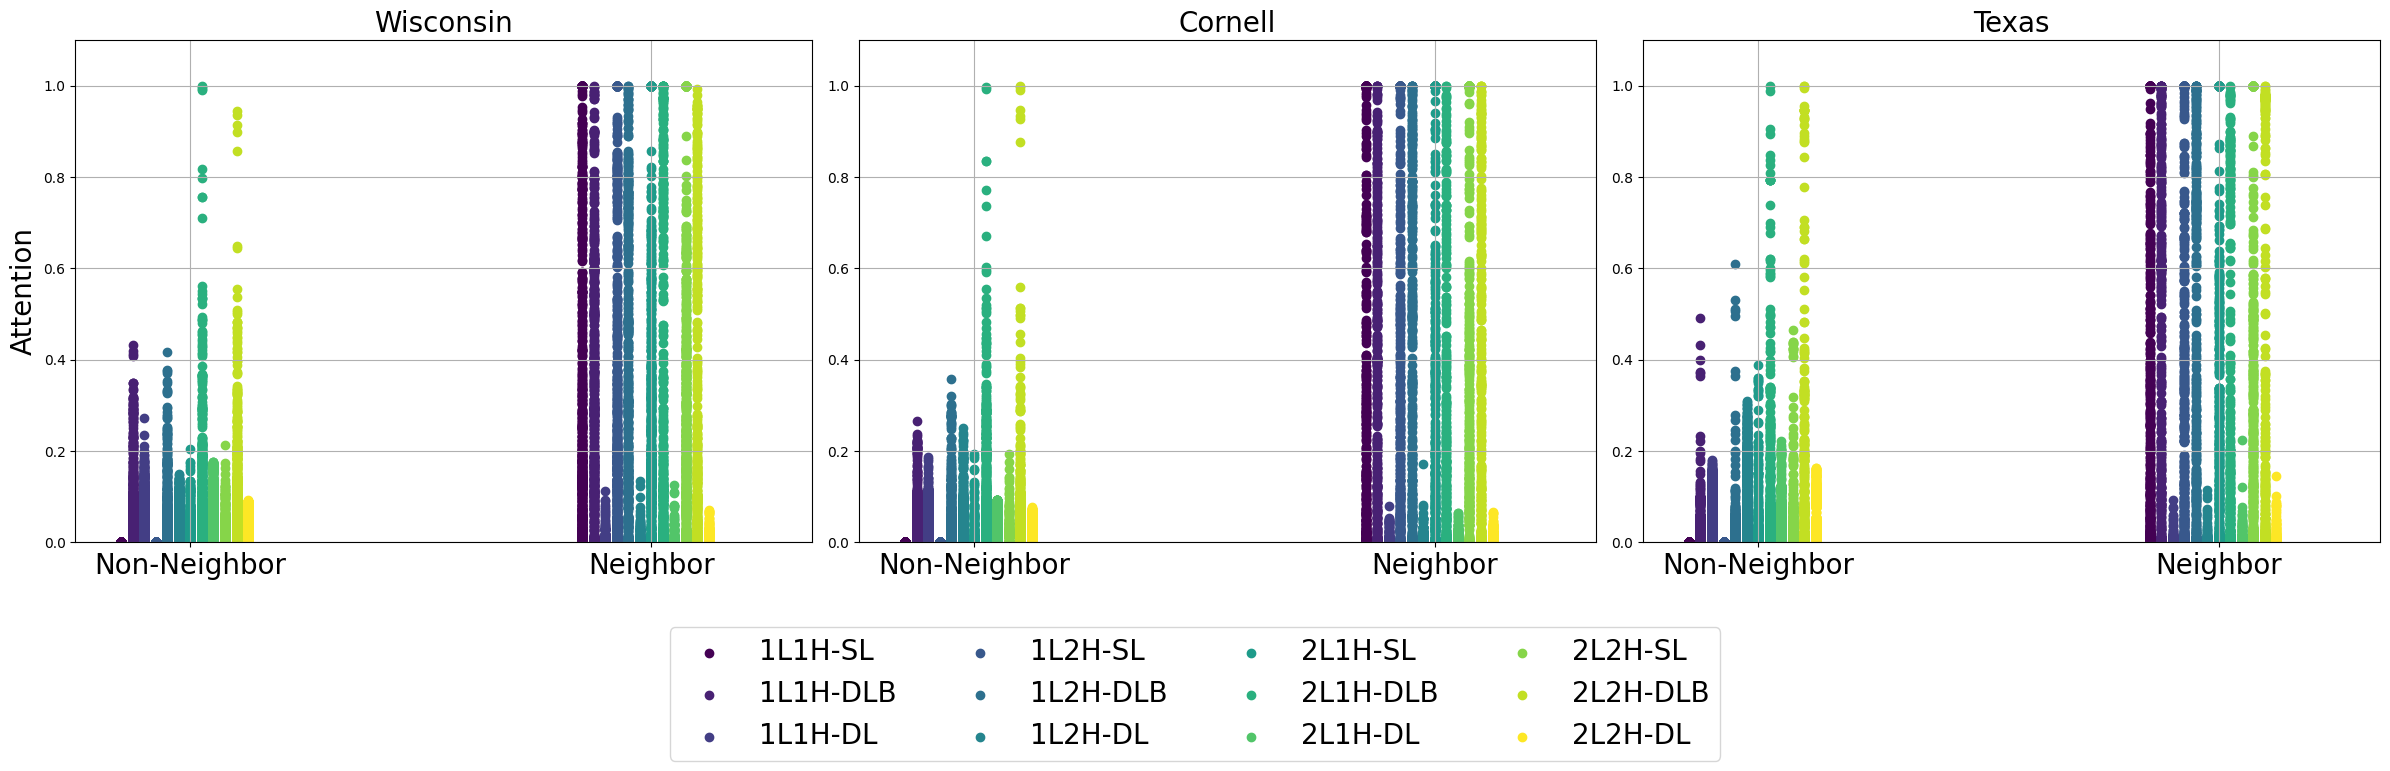

In [32]:
### Figure 1 ###

import matplotlib.pyplot as plt
import numpy as np

# data_key = 'Cora'
# metric = 'st_avg'

metrics = ['st_avg', 'dt_avg', 'dt2_avg']
metrics_labels = {'st_avg':'SL', 'dt_avg':'DLB', 'dt2_avg':'DL'}
model_specs = {'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

DATASETS1 = {key:DATASETS[key] for key in list(DATASETS.keys())[:4]}
DATASETS2 = {key:DATASETS[key] for key in list(DATASETS.keys())[4:]}

DATASET_CURR = DATASETS2
x_min, x_max = -0.1, 1.5
y_min, y_max = 0, 1.1

fig, axes = plt.subplots(1, len(DATASET_CURR), figsize=(24, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(model_specs) * len(metrics)))


for idx, (ax, (data_key, data_value)) in enumerate(zip(axes, DATASET_CURR.items())):
    color_idx = 0
    add = 0
    for model_spec in model_specs:
        all_attns = model_specs[model_spec]
        for metric in metrics:
            attn = all_attns[data_key][metric].flatten()
            adj = data_value["dense_adj"].flatten()
            adj[adj == 2] = 1
            label_ = f'{model_spec}-{metrics_labels[metric]}'

            ax.scatter((adj.cpu() + add).numpy(), attn.cpu().numpy(), label=label_, c=colors[color_idx], marker='o')
            ax.set_title(f'{data_key}', fontsize=20)
            ax.set_xticks([0.15, 1.15])
            ax.set_xticklabels(['Non-Neighbor', 'Neighbor'], fontsize=20)
            if idx == 0:
                ax.set_ylabel('Attention', fontsize=20)
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.grid(True)
            color_idx += 1
            add += 0.025

plt.tight_layout()
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles[:12], labels[:12], loc='lower center',  ncol=4, fontsize=20, bbox_to_anchor=(0.5, -0.3))
plt.show()

In [61]:
# # Ensure DATASET_CURR is correct
# DATASET_CURR = DATASETS1

# x_min, x_max = -0.1, 1.5
# y_min, y_max = 0, 1.1

# fig, axes = plt.subplots(1, len(DATASET_CURR), figsize=(24, 6))
# colors = plt.cm.viridis(np.linspace(0, 1, len(model_specs) * len(metrics)))

# for idx, (ax, (data_key, data_value)) in enumerate(zip(axes, DATASET_CURR.items())):
#     color_idx = 0
#     add = 0
#     for model_spec in model_specs:
#         all_attns = model_specs[model_spec]
#         for metric in metrics:
#             attn = all_attns[data_key][metric].flatten().cpu().numpy()
#             adj = data_value["dense_adj"].flatten().cpu().numpy()
#             adj[adj == 2] = 1
#             label_ = f'{model_spec}-{metrics_labels[metric]}'

#             ax.scatter(adj + add, attn, label=label_, c=[colors[color_idx]], marker='o')
#             ax.set_title(f'{data_key}', fontsize=20)
#             ax.set_xticks([0.15, 1.15])
#             ax.set_xticklabels(['Non-Neighbor', 'Neighbor'], fontsize=20)
#             if idx == 0:
#                 ax.set_ylabel('Attention', fontsize=20)
#             ax.set_xlim(x_min, x_max)
#             ax.set_ylim(y_min, y_max)
#             ax.grid(True)
#             color_idx += 1
#             add += 0.025

# plt.tight_layout()
# handles, labels = fig.gca().get_legend_handles_labels()
# fig.legend(handles[:12], labels[:12], loc='lower center', ncol=4, fontsize=20, bbox_to_anchor=(0.5, -0.3))
# plt.show()

### Figure 2: Attention to N-hop Neighborhood: 1Layer 1Head

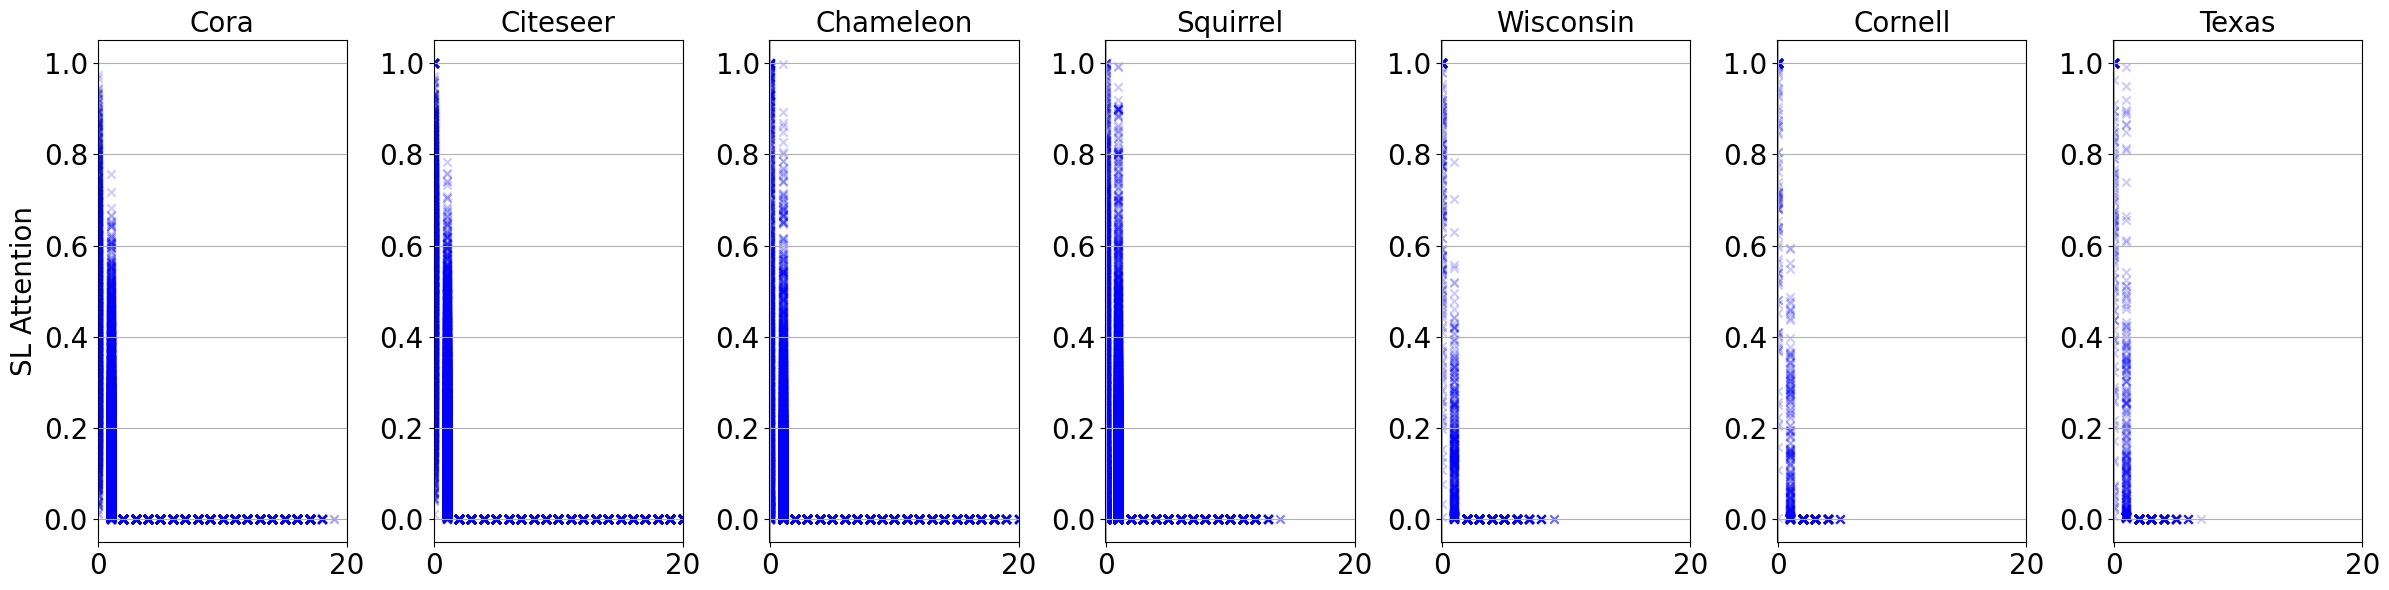

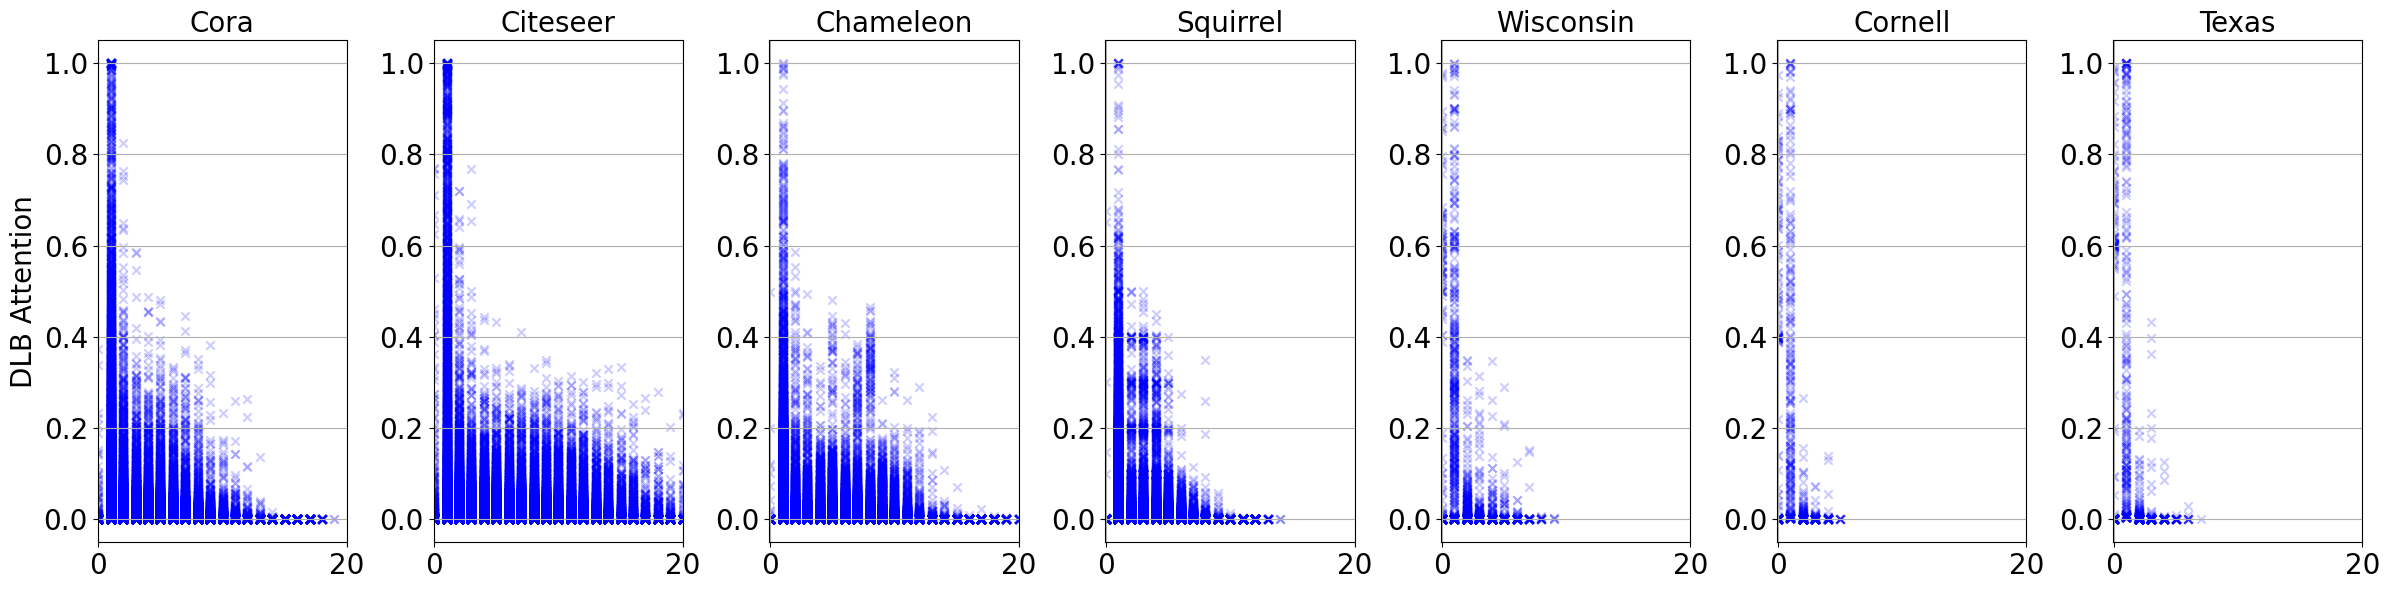

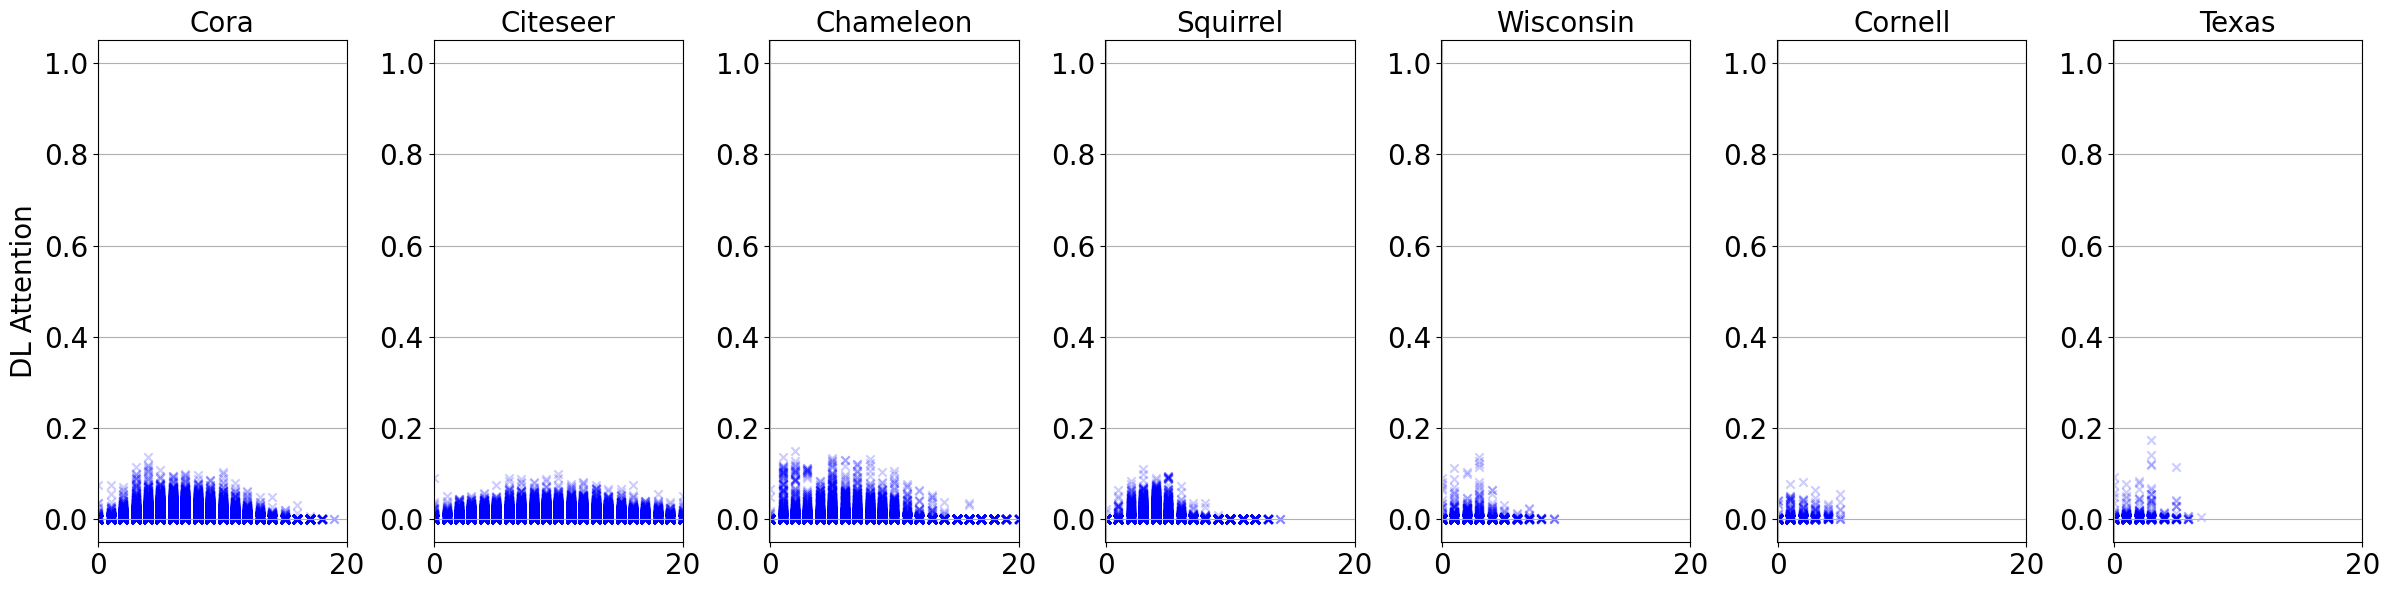

In [36]:
import matplotlib.pyplot as plt
import numpy as np

metric = 'dt_avg'
metrics = ['st_avg', 'dt_avg', 'dt2_avg']
metrics_labels = {'st_avg': 'SL', 'dt_avg': 'DLB', 'dt2_avg': 'DL'}

DATASETS1 = {key: DATASETS[key] for key in list(DATASETS.keys())[:4]}
DATASETS2 = {key: DATASETS[key] for key in list(DATASETS.keys())[4:]}

model_specs = [A1L_1H]

DATASET_CURR = DATASETS

x_min, x_max = -0.05, 20
y_min, y_max = -0.05, 1.05

for metric in metrics:
    for all_attns in model_specs:
        fig, axes = plt.subplots(1, len(DATASET_CURR), figsize=(24, 6))
        for ax, (data_key, data_value) in zip(axes, DATASET_CURR.items()):
            attn = all_attns[data_key][metric].flatten().cpu().numpy()
            sp = data_value["dense_sp_matrix"].flatten().cpu().numpy()

            ax.scatter(sp, attn, marker='x', color='blue', alpha=0.2)
            ax.set_title(f'{data_key}', fontsize=20)

            if data_key == 'Cora':
                ax.set_ylabel(f'{metrics_labels[metric]} Attention', fontsize=20)
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.grid(True)

        plt.tight_layout()
        plt.show()

### [NOT INCLUDED] Expected N-Hop Attention per Class

In [ ]:
### Figure 3 ###

from matplotlib.ticker import MaxNLocator

DATASETS1 = {key:DATASETS[key] for key in list(DATASETS.keys())[:4]}
DATASETS2 = {key:DATASETS[key] for key in list(DATASETS.keys())[4:]}

DATASET_CURR = DATASETS2

model_specs = [A1L_1H, A1L_2H, A2L_1H, A2L_2H ]

model_key = 'dt2_avg'
n_datasets = len(DATASET_CURR)

for all_attns in model_specs:
  fig, axes = plt.subplots(1, n_datasets, figsize=(10 * n_datasets, 6))  # Adjust the figure size as needed
  for idx, (data_key, ax) in enumerate(zip(DATASET_CURR, axes.flatten())):
    sp_curr = DATASETS[data_key].dense_sp_matrix.cuda()
    sp_curr = torch.nan_to_num(sp_curr, posinf=0)
    attention_curr = all_attns[data_key][model_key].cpu()
    expected_attention = np.array([(attention_curr[i] * sp_curr[i].cpu()).sum().cpu().item() for i in range(attention_curr.shape[0])])
    classes = DATASETS[data_key].y.cpu().numpy()

    # Calculate the mean expected attention for each class
    unique_classes = np.unique(classes)
    mean_attentions = [np.mean(expected_attention[classes == cls]) for cls in unique_classes]

    # Scatter plot for individual data points
    ax.scatter(classes, expected_attention, color='black', s=50, label=f'Dataset {data_key} Data')

    # Bar chart for mean expected attention
    ax.bar(unique_classes, mean_attentions, color='blue', alpha=0.2, label=f'Dataset {data_key} Mean')

    ax.set_title(f'{data_key}: Classes vs. Expected Attention')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Expected Attention')
    ax.grid(True)
    ax.legend(title='Legend')

    # Ensure that only integer values are shown on the x-axis
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.tight_layout()
  plt.show()

# Analysis Part II: A framework to analyze a model with multiple heads and layers

**Combining Attention**

*   We combine the attention matrices across heads by averaging across heads. This gives us how much a node attends to another on average.

*   We combine the attention matrices across layers by matrix multiplying $A_{L2} A_{L1}$. This gives us how much a node attends to another across layers.

In [37]:
### Combined Attention Matrices ###

model_keys = ['st_avg', 'dt_avg', 'dt2_avg']
data_keys = list(DATASETS.keys())
A1L_1H = {data_key: {model_key: all_attns_1L_1H[data_key][model_key].mean(axis=1)[0] for model_key in model_keys} for data_key in data_keys}
A1L_2H = {data_key: {model_key: all_attns_1L_2H[data_key][model_key].mean(axis=1)[0]  for model_key in model_keys} for data_key in data_keys}
A2L_1H = {data_key: {model_key: (all_attns_2L_1H[data_key][model_key].mean(axis=1)[1] @ all_attns_2L_1H[data_key][model_key].mean(axis=1)[0]).cpu() for model_key in model_keys} for data_key in data_keys}
A2L_2H = {data_key: {model_key: (all_attns_2L_2H[data_key][model_key].mean(axis=1)[1] @ all_attns_2L_2H[data_key][model_key].mean(axis=1)[0]).cpu() for model_key in model_keys} for data_key in data_keys}

## Section 2.1: Do the heads learn the same patterns?

### [NOT INCLUDED] N-Hop Neighborhood Attendance Comparison for 2 Heads (1L2H Model)

In [ ]:
### Figure 2 ###

import matplotlib.pyplot as plt
import numpy as np

num_heads = 2

# data_key = 'Cora'
metric = 'dt2_avg'

# Figure 2 subplots
DATASETS1 = {key:DATASETS[key] for key in list(DATASETS.keys())[:4]}
DATASETS2 = {key:DATASETS[key] for key in list(DATASETS.keys())[4:]}

DATASET_CURR = DATASETS2

all_attns = all_attns_2L_2H
x_min, x_max = 0, 10
y_min, y_max = 0, 0.5

fig, axes = plt.subplots(1, len(DATASET_CURR), figsize=(24, 6))
for ax, (data_key, data_value) in zip(axes, DATASET_CURR.items()):
    attn = all_attns[data_key][metric][0]
    sp = data_value["dense_sp_matrix"]
    for head_idx in range(num_heads):
      attn = all_attns[data_key][metric][0][head_idx]
      print(sp.cpu().shape,  attn.cpu().shape)
      ax.scatter(sp.cpu()+0.1*head_idx, attn.cpu())
    # ax.scatter(sp.cpu(), attn.cpu(), marker='x', color='blue')#,c=attn.cpu(), cmap='icefire')
    ax.set_title(f'{data_key}: Attention Paid to N-hop Neighborhood')
    ax.set_xlabel('N-Hop Neighborhood')
    ax.set_ylabel('Attention')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Figure 3: Comparison of Head Attention Patterns

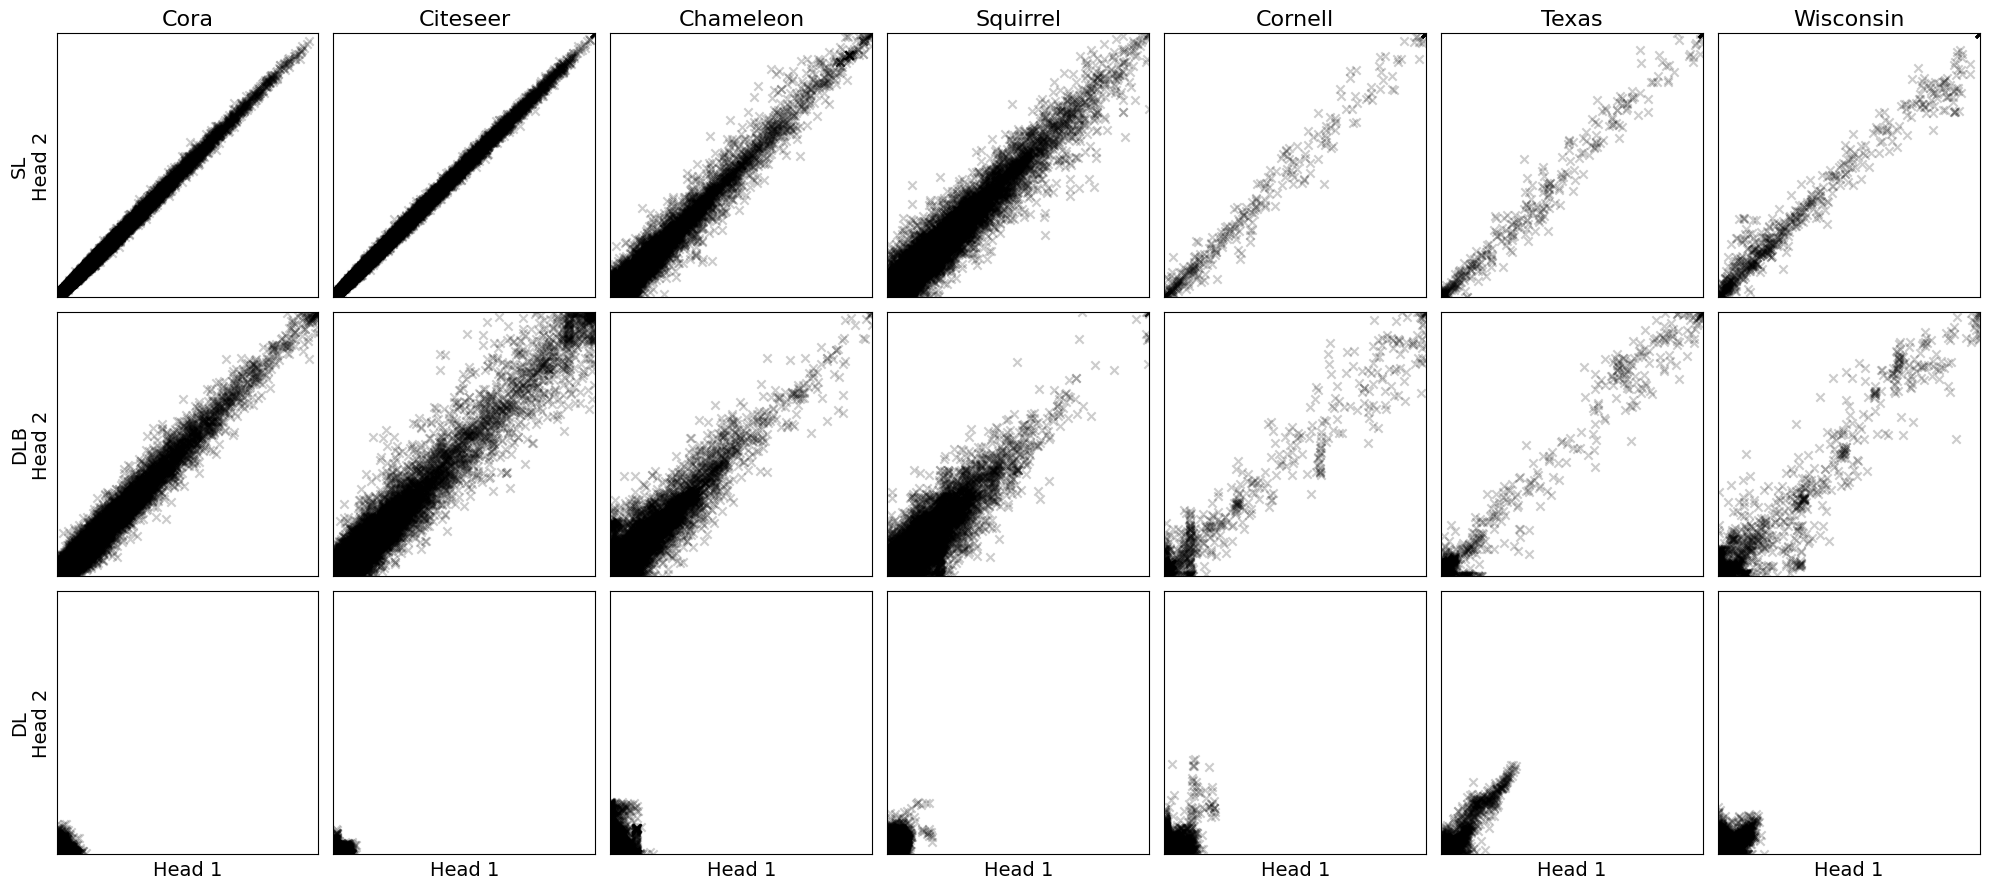

In [39]:
import matplotlib.pyplot as plt

data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin']
metrics = ['st_avg', 'dt_avg', 'dt2_avg']
metrics_labels = {'st_avg': 'SL', 'dt_avg': 'DLB', 'dt2_avg': 'DL'}

x_min, x_max = 0, 1
y_min, y_max = 0, 1

fig, axs = plt.subplots(len(metrics), len(data_keys), figsize=(20, 9))

for i, model_name in enumerate(metrics):
    for j, dataset_name in enumerate(data_keys):
        head_1 = all_attns_1L_2H[dataset_name][model_name][0][0].cpu().numpy()
        head_2 = all_attns_1L_2H[dataset_name][model_name][0][1].cpu().numpy()

        axs[i, j].scatter(head_1, head_2, color='black', marker='x', alpha=0.2)

        if i == 0:
            axs[i, j].set_title(dataset_name, fontsize=16)

        if j == 0:
            axs[i, j].set_ylabel(f'{metrics_labels[model_name]}\nHead 2', fontsize=14)

        if i == len(metrics) - 1:
            axs[i, j].set_xlabel('Head 1', fontsize=14)

        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

        axs[i, j].set_xlim(x_min, x_max)
        axs[i, j].set_ylim(y_min, y_max)
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

## Section 2.2: Do the layers learn the same pattern?

### Figure 4: Comparison of Layer Attention Patterns

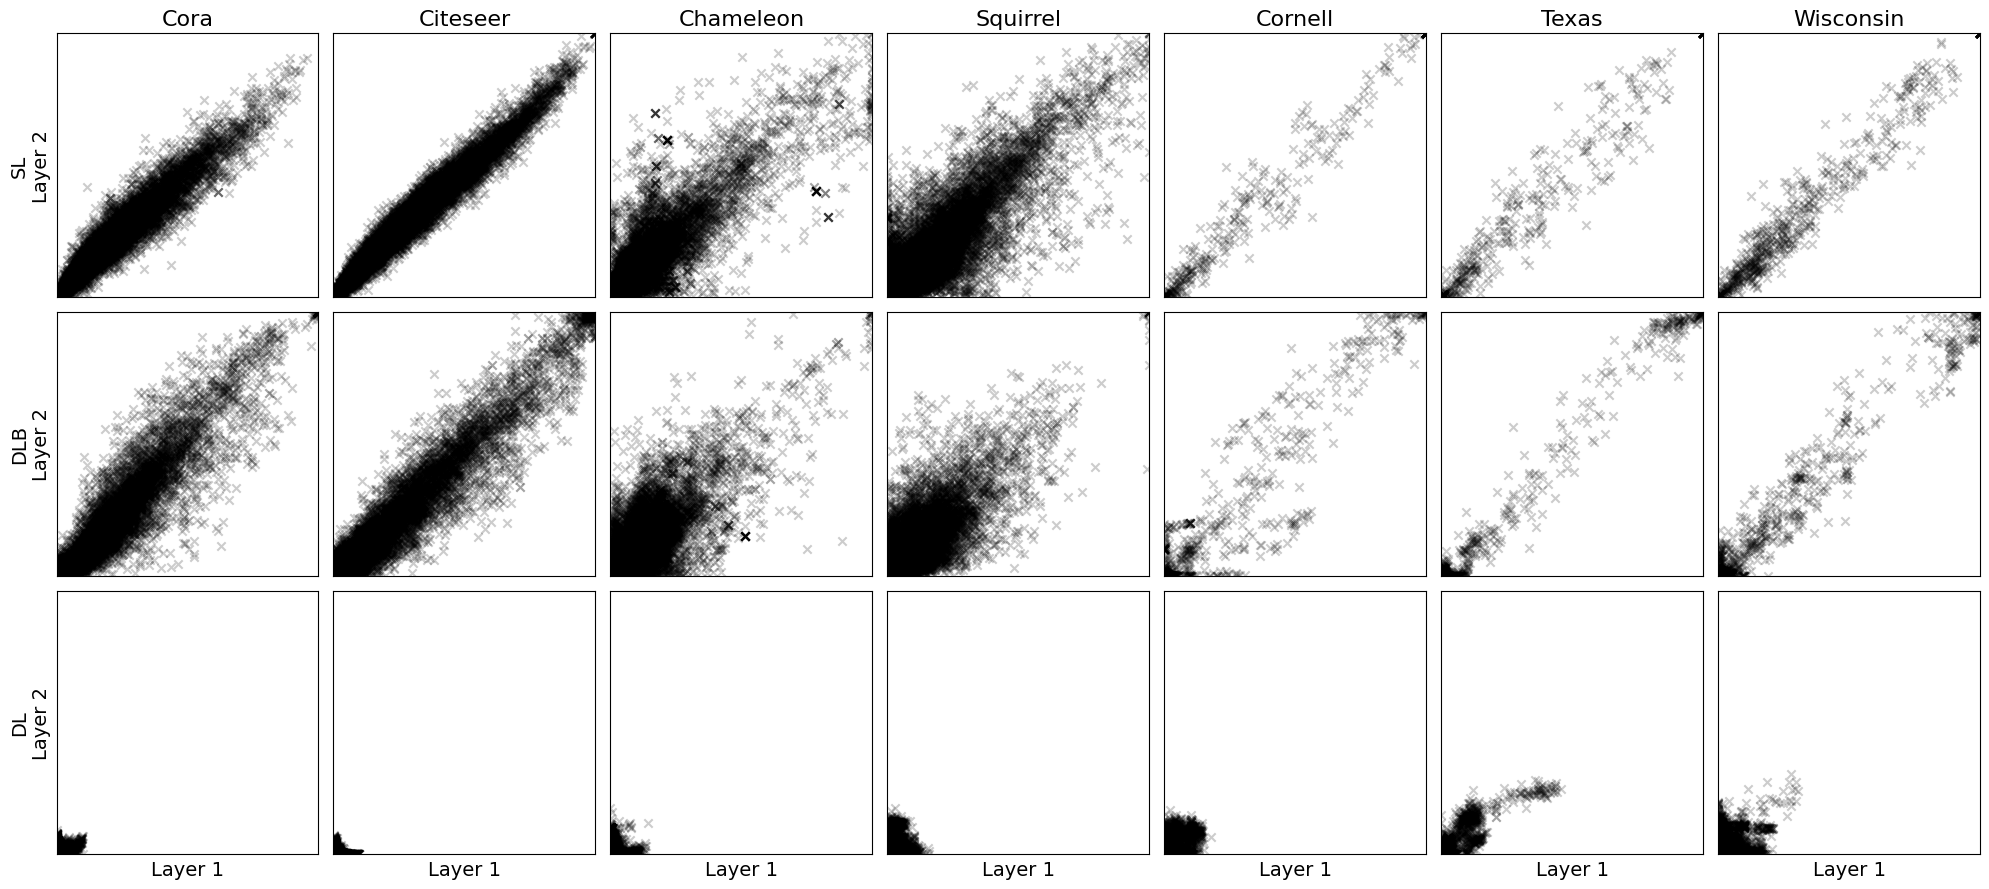

In [60]:
import matplotlib.pyplot as plt

data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin']
metrics = ['st_avg', 'dt_avg', 'dt2_avg']
metrics_labels = {'st_avg': 'SL', 'dt_avg': 'DLB', 'dt2_avg': 'DL'}

x_min, x_max = 0, 1
y_min, y_max = 0, 1

fig, axs = plt.subplots(len(metrics), len(data_keys), figsize=(20, 9))

for i, model_name in enumerate(metrics):
    for j, dataset_name in enumerate(data_keys):
        layer1 = all_attns_2L_1H[dataset_name][model_name][0][0].cpu().numpy()
        layer2 = all_attns_2L_1H[dataset_name][model_name][1][0].cpu().numpy()

        axs[i, j].scatter(layer1, layer2, color='black', marker='x', alpha=0.2)

        if i == 0:
            axs[i, j].set_title(dataset_name, fontsize=16)

        if j == 0:
            axs[i, j].set_ylabel(f'{metrics_labels[model_name]}\nLayer 2', fontsize=14)

        if i == len(metrics) - 1:
            axs[i, j].set_xlabel('Layer 1', fontsize=14)

        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

        axs[i, j].set_xlim(x_min, x_max)
        axs[i, j].set_ylim(y_min, y_max)
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

## [NOT INCLUDED] Section 2.3: Do the Models learn the same pattern?

### [NOT INCLUDED] Model Comparison

In [ ]:
data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin'] #list(DATASETS.keys())
metrics = ['st_avg', 'dt_avg', 'dt2_avg']
metrics_labels = {'st_avg':'SparseT', 'dt_avg':'DenseTwB', 'dt2_avg':'DenseT'}
model_specs ={'1L1H': A1L_1H, '2L2H': A2L_2H} #{'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

for metric in metrics:
  for dataset_name in data_keys:
      plt.title(dataset_name)
      plt.scatter(A1L_1H[dataset_name][metric].cpu(), A2L_2H[dataset_name][metric].cpu())
      plt.show()

# Analysis Part III: Does the  graph structure in attention recover the original graph structure?

## Section 3.1: Combining Attention Matrices

In [41]:
### Combined Attention Matrices ###

data_keys = list(DATASETS.keys())
A1L_1H = {data_key: {model_key: all_attns_1L_1H[data_key][model_key].mean(axis=1)[0] for model_key in model_keys} for data_key in data_keys}
A1L_2H = {data_key: {model_key: all_attns_1L_2H[data_key][model_key].mean(axis=1)[0]  for model_key in model_keys} for data_key in data_keys}
A2L_1H = {data_key: {model_key: (all_attns_2L_1H[data_key][model_key].mean(axis=1)[1] @ all_attns_2L_1H[data_key][model_key].mean(axis=1)[0]).cpu() for model_key in model_keys} for data_key in data_keys}
A2L_2H = {data_key: {model_key: (all_attns_2L_2H[data_key][model_key].mean(axis=1)[1] @ all_attns_2L_2H[data_key][model_key].mean(axis=1)[0]).cpu() for model_key in model_keys} for data_key in data_keys}

## Section 3.2: Selecting a Threshold [Commented Out]

In [64]:
# import numpy as np

# model_keys = ['dt_avg', 'dt2_avg']
# data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin']
# model_specs = {'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

# thresholds = np.arange(0, 1, 0.001)  # Example range of thresholds
# selected_thresholds = {}

# for spec_key in model_specs:
#   print(spec_key)
#   spec = model_specs[spec_key]
#   selected_thresholds[spec_key] = {}
#   for data_key in data_keys:
#       selected_thresholds[spec_key][data_key] = {}
#       for model_key in model_keys:
#           adj = DATASETS[data_key].dense_adj.cpu()
#           attn_base = spec[data_key][model_key].cpu()

#           best_threshold = 0
#           min_difference = float('inf')

#           for threshold in thresholds:
#               attn = attn_base.clone()
#               attn[attn >= threshold] = 1
#               attn[attn < threshold] = 0

#               difference = abs(adj.sum() - attn.sum())
#               if difference < min_difference:
#                   min_difference = difference
#                   best_threshold = threshold

#           # Now, best_threshold is the threshold where the difference between sums is minimized.
#           print(f"Best threshold {data_key} - {model_key}: {best_threshold}")
#           print(f"Difference: {min_difference}")
#           selected_thresholds[spec_key][data_key][model_key] = best_threshold

##############
### Output ###
##############

# 1L1H
# Best threshold Cora - dt_avg: 0.037
# Difference: 87.0
# Best threshold Cora - dt2_avg: 0.019
# Difference: 470.0
# Best threshold Citeseer - dt_avg: 0.06
# Difference: 33.0
# Best threshold Citeseer - dt2_avg: 0.02
# Difference: 743.0
# Best threshold Chameleon - dt_avg: 0.006
# Difference: 243.0
# Best threshold Chameleon - dt2_avg: 0.006
# Difference: 2515.0
# Best threshold Squirrel - dt_avg: 0.003
# Difference: 3929.0
# Best threshold Squirrel - dt2_avg: 0.001
# Difference: 86327.0
# Best threshold Cornell - dt_avg: 0.079
# Difference: 2.0
# Best threshold Cornell - dt2_avg: 0.06
# Difference: 1.0
# Best threshold Texas - dt_avg: 0.039
# Difference: 4.0
# Best threshold Texas - dt2_avg: 0.07200000000000001
# Difference: 4.0
# Best threshold Wisconsin - dt_avg: 0.058
# Difference: 5.0
# Best threshold Wisconsin - dt2_avg: 0.051000000000000004
# Difference: 10.0
# 1L2H
# Best threshold Cora - dt_avg: 0.024
# Difference: 39.0
# Best threshold Cora - dt2_avg: 0.015
# Difference: 560.0
# Best threshold Citeseer - dt_avg: 0.054
# Difference: 69.0
# Best threshold Citeseer - dt2_avg: 0.012
# Difference: 1171.0
# Best threshold Chameleon - dt_avg: 0.005
# Difference: 505.0
# Best threshold Chameleon - dt2_avg: 0.006
# Difference: 4235.0
# Best threshold Squirrel - dt_avg: 0.003
# Difference: 10409.0
# Best threshold Squirrel - dt2_avg: 0.001
# Difference: 147306.0
# Best threshold Cornell - dt_avg: 0.049
# Difference: 2.0
# Best threshold Cornell - dt2_avg: 0.054
# Difference: 13.0
# Best threshold Texas - dt_avg: 0.034
# Difference: 3.0
# Best threshold Texas - dt2_avg: 0.059000000000000004
# Difference: 0.0
# Best threshold Wisconsin - dt_avg: 0.049
# Difference: 3.0
# Best threshold Wisconsin - dt2_avg: 0.052000000000000005
# Difference: 23.0
# 2L1H
# Best threshold Cora - dt_avg: 0.038
# Difference: 98.0
# Best threshold Cora - dt2_avg: 0.008
# Difference: 801.0
# Best threshold Citeseer - dt_avg: 0.044
# Difference: 29.0
# Best threshold Citeseer - dt2_avg: 0.007
# Difference: 1769.0
# Best threshold Chameleon - dt_avg: 0.014
# Difference: 825.0
# Best threshold Chameleon - dt2_avg: 0.005
# Difference: 2650.0
# Best threshold Squirrel - dt_avg: 0.005
# Difference: 33406.0
# Best threshold Squirrel - dt2_avg: 0.001
# Difference: 8669.0
# Best threshold Cornell - dt_avg: 0.08
# Difference: 0.0
# Best threshold Cornell - dt2_avg: 0.05
# Difference: 7.0
# Best threshold Texas - dt_avg: 0.056
# Difference: 2.0
# Best threshold Texas - dt2_avg: 0.036000000000000004
# Difference: 9.0
# Best threshold Wisconsin - dt_avg: 0.046
# Difference: 2.0
# Best threshold Wisconsin - dt2_avg: 0.065
# Difference: 13.0
# 2L2H
# Best threshold Cora - dt_avg: 0.039
# Difference: 42.0
# Best threshold Cora - dt2_avg: 0.007
# Difference: 2419.0
# Best threshold Citeseer - dt_avg: 0.041
# Difference: 101.0
# Best threshold Citeseer - dt2_avg: 0.006
# Difference: 856.0
# Best threshold Chameleon - dt_avg: 0.013000000000000001
# Difference: 432.0
# Best threshold Chameleon - dt2_avg: 0.004
# Difference: 4218.0
# Best threshold Squirrel - dt_avg: 0.005
# Difference: 39171.0
# Best threshold Squirrel - dt2_avg: 0.001
# Difference: 22364.0
# Best threshold Cornell - dt_avg: 0.052000000000000005
# Difference: 4.0
# Best threshold Cornell - dt2_avg: 0.048
# Difference: 9.0
# Best threshold Texas - dt_avg: 0.02
# Difference: 4.0
# Best threshold Texas - dt2_avg: 0.047
# Difference: 32.0
# Best threshold Wisconsin - dt_avg: 0.057
# Difference: 2.0
# Best threshold Wisconsin - dt2_avg: 0.048
# Difference: 1.0

In [65]:
# Save the thresholds
# import json
# file_path = 'drive/MyDrive/Colab Notebooks/L65/selected_thresholds_dict.pkl'
# with open(file_path, 'w') as file:
#     json.dump(selected_thresholds, file)

## Section 3.3: Analyzing Thresholded Attention

### Figure 5: Attention Heatmaps

In [66]:
import json
# Load the thresholds
file_path = 'drive/MyDrive/Colab Notebooks/L65/selected_thresholds_dict.pkl'
with open(file_path, 'r') as file:
    selected_thresholds = json.load(file)

In [53]:
model_keys = ['dt_avg', 'dt2_avg']
metrics_labels = {'st_avg':'SL', 'dt_avg':'DLB', 'dt2_avg':'DL'}
data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin'] #list(DATASETS.keys())
model_specs = {'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

thresholded_attentions = {}

thresholded_attentions = {}
for spec_key in model_specs:
  spec = model_specs[spec_key]
  print(spec_key)
  thresholded_attentions[spec_key] = {}
  for data_key in data_keys:
    thresholded_attentions[spec_key][data_key] = {}
    for model_key in model_keys:
      threshold = selected_thresholds[spec_key][data_key][model_key]
      attn = spec[data_key][model_key].cpu()
      attn[attn>=threshold] = 1
      attn[attn<threshold] = 0
      thresholded_attentions[spec_key][data_key][metrics_labels[model_key]] = attn

1L1H
1L2H
2L1H
2L2H


In [54]:
thresholded_attentions

{'1L1H': {'Cora': {'DLB': tensor[2708, 2708] n=7333264 (28Mb) x∈[0., 1.000] μ=0.002 σ=0.043,
   'DL': tensor[2708, 2708] n=7333264 (28Mb) x∈[0., 1.000] μ=0.002 σ=0.043},
  'Citeseer': {'DLB': tensor[3327, 3327] n=11068929 (42Mb) x∈[0., 1.000] μ=0.001 σ=0.034,
   'DL': tensor[3327, 3327] n=11068929 (42Mb) x∈[0., 1.000] μ=0.001 σ=0.032},
  'Chameleon': {'DLB': tensor[2277, 2277] n=5184729 (20Mb) x∈[0., 1.000] μ=0.007 σ=0.086,
   'DL': tensor[2277, 2277] n=5184729 (20Mb) x∈[0., 1.000] μ=0.008 σ=0.088},
  'Squirrel': {'DLB': tensor[5201, 5201] n=27050401 (0.1Gb) x∈[0., 1.000] μ=0.008 σ=0.091,
   'DL': tensor[5201, 5201] n=27050401 (0.1Gb) x∈[0., 1.000] μ=0.005 σ=0.071},
  'Cornell': {'DLB': tensor[183, 183] n=33489 (0.1Mb) x∈[0., 1.000] μ=0.014 σ=0.118,
   'DL': tensor[183, 183] n=33489 (0.1Mb) x∈[0., 1.000] μ=0.014 σ=0.119},
  'Texas': {'DLB': tensor[183, 183] n=33489 (0.1Mb) x∈[0., 1.000] μ=0.015 σ=0.120,
   'DL': tensor[183, 183] n=33489 (0.1Mb) x∈[0., 1.000] μ=0.015 σ=0.121},
  'Wiscon

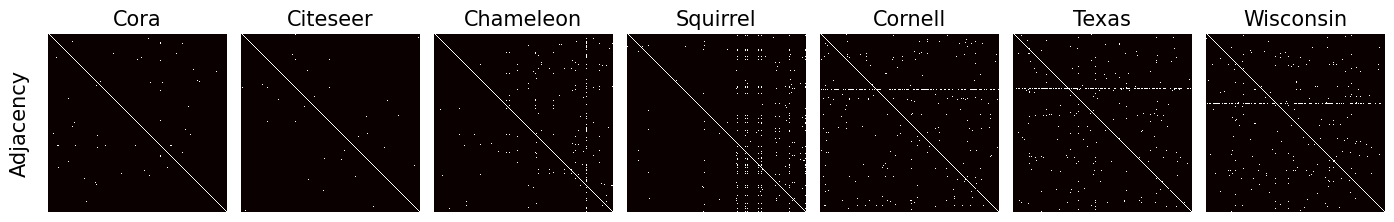

In [55]:
model_keys = ['dt_avg', 'dt2_avg']
metrics_labels = {'st_avg':'SL', 'dt_avg':'DLB', 'dt2_avg':'DL'}
data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin'] #list(DATASETS.keys())
model_specs = {'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 7, figsize=(14, 4))

for j in range(7):
    data = DATASETS[data_keys[j]].dense_adj.cpu()
    axs[j].imshow(data, cmap='hot', interpolation='nearest')
    axs[j].set_title(data_keys[j], fontsize=15)
    if j == 0:
      axs[j].text(-0.1, 0.5, 'Adjacency', transform=axs[j].transAxes, va='center', ha='right', rotation=90, fontsize=15)
    axs[j].axis('off')  # Turn off the axis
plt.tight_layout()
plt.show()

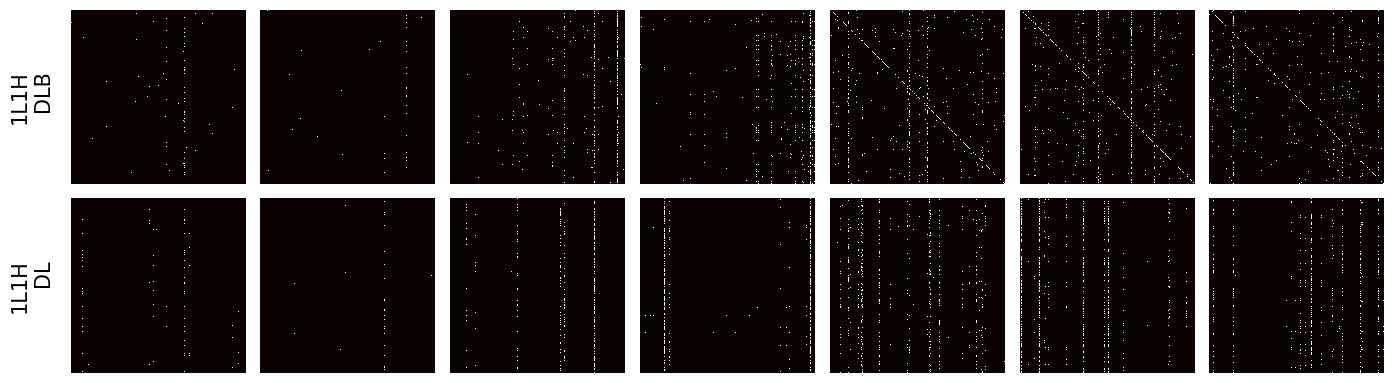

In [56]:
spec_key = '1L1H'
fig, axs = plt.subplots(2, 7, figsize=(14, 4))

for i in range(2):
    for j in range(7):
        data = thresholded_attentions[spec_key][data_keys[j]][metrics_labels[model_keys[i]]]
        axs[i, j].imshow(data, cmap='hot', interpolation='nearest')
        axs[i, j].axis('off')  # Turn off the axis
        if j == 0:
            axs[i, j].text(-0.1, 0.5, f'{spec_key}\n{metrics_labels[model_keys[i]]}',
                           transform=axs[i, j].transAxes, va='center', ha='right',
                           rotation=90, fontsize=15)
plt.tight_layout()
plt.show()

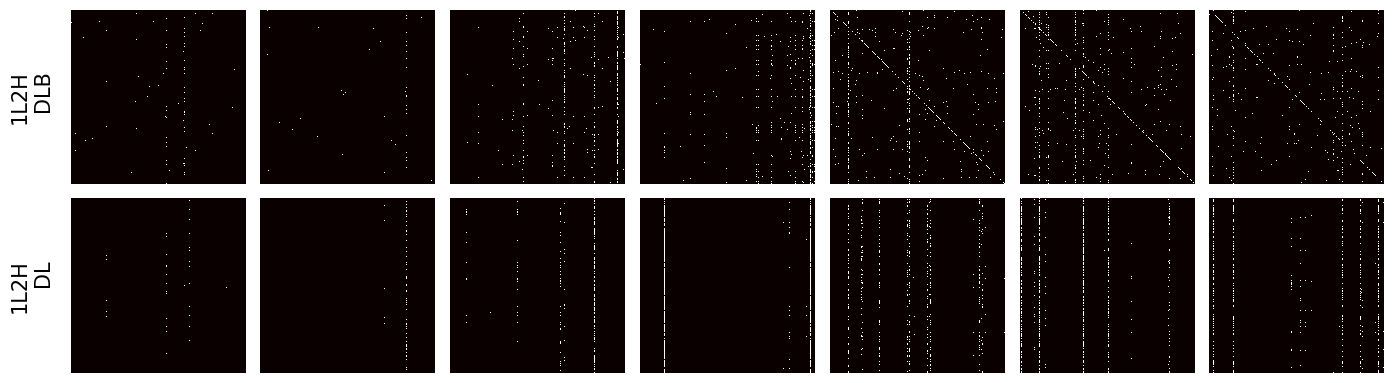

In [57]:
spec_key = '1L2H'
fig, axs = plt.subplots(2, 7, figsize=(14, 4))
for i in range(2):
    for j in range(7):
        data = thresholded_attentions[spec_key][data_keys[j]][metrics_labels[model_keys[i]]]
        axs[i, j].imshow(data, cmap='hot', interpolation='nearest')
        axs[i, j].axis('off')  # Turn off the axis
        if j == 0:
            axs[i, j].text(-0.1, 0.5, f'{spec_key}\n{metrics_labels[model_keys[i]]}',
                           transform=axs[i, j].transAxes, va='center', ha='right',
                           rotation=90, fontsize=15)
plt.tight_layout()
plt.show()

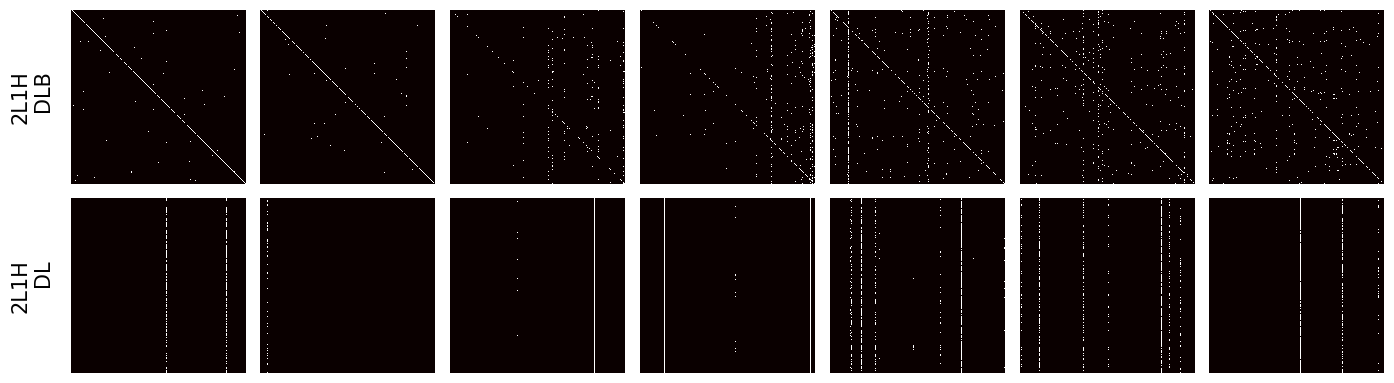

In [58]:
spec_key = '2L1H'
fig, axs = plt.subplots(2, 7, figsize=(14, 4))
for i in range(2):
    for j in range(7):
        data = thresholded_attentions[spec_key][data_keys[j]][metrics_labels[model_keys[i]]]
        axs[i, j].imshow(data, cmap='hot', interpolation='nearest')
        axs[i, j].axis('off')  # Turn off the axis
        if j == 0:
            axs[i, j].text(-0.1, 0.5, f'{spec_key}\n{metrics_labels[model_keys[i]]}',
                           transform=axs[i, j].transAxes, va='center', ha='right',
                           rotation=90, fontsize=15)
plt.tight_layout()
plt.show()

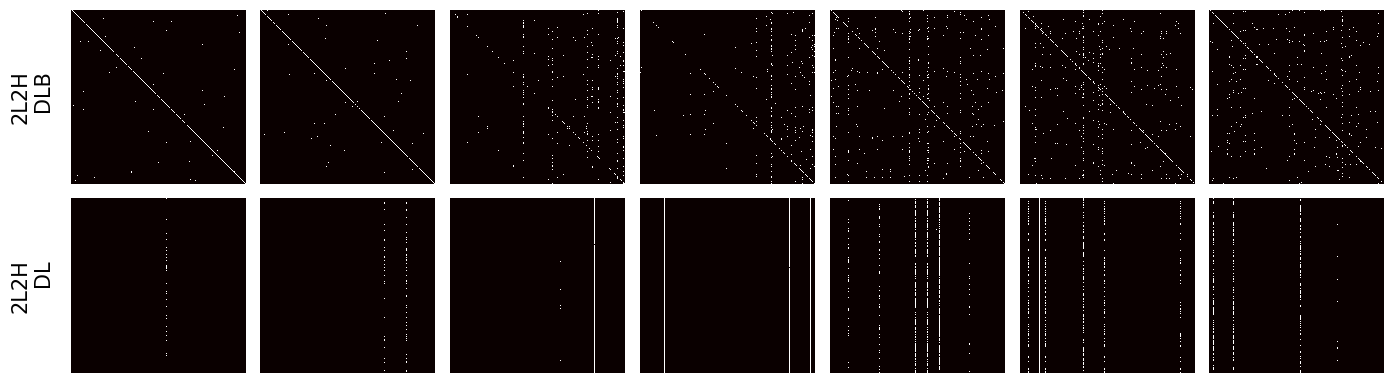

In [59]:
spec_key = '2L2H'
fig, axs = plt.subplots(2, 7, figsize=(14, 4))
for i in range(2):
    for j in range(7):
        data = thresholded_attentions[spec_key][data_keys[j]][metrics_labels[model_keys[i]]]
        axs[i, j].imshow(data, cmap='hot', interpolation='nearest')
        axs[i, j].axis('off')  # Turn off the axis
        if j == 0:
            axs[i, j].text(-0.1, 0.5, f'{spec_key}\n{metrics_labels[model_keys[i]]}',
                           transform=axs[i, j].transAxes, va='center', ha='right',
                           rotation=90, fontsize=15)
plt.tight_layout()
plt.show()

### Table 4: Adjacency Recovery: P, R, F1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef

model_keys = ['dt_avg', 'dt2_avg']
metrics_labels = {'st_avg':'SparseT', 'dt_avg':'DenseTwB', 'dt2_avg':'DenseT'}
data_keys = ['Cora', 'Citeseer', 'Chameleon', 'Squirrel', 'Cornell', 'Texas', 'Wisconsin'] #list(DATASETS.keys())
model_specs = {'1L1H': A1L_1H, '1L2H': A1L_2H, '2L1H': A2L_1H, '2L2H': A2L_2H }

results = {}
for spec_key in model_specs:
  spec = model_specs[spec_key]
  print(spec_key)
  results[spec_key] = {}
  for data_key in data_keys:
    results[spec_key][data_key] = {}
    for model_key in model_keys:
      attn = thresholded_attentions[spec_key][data_key][metrics_labels[model_key]]
      adj =  DATASETS[data_key].dense_adj.cpu()
      f1 = f1_score(adj.flatten(), (attn >= 1).flatten())
      p = precision_score(adj.flatten(), (attn >= 1).flatten())
      r = recall_score(adj.flatten(), (attn >= 1).flatten())
      # Simple silarity metrics between true adjacency matrix and learnt adjacency matrix (attn)
      print("F1 Score: {:.4f}".format(f1_score(adj.flatten(), (attn >= 1).flatten())))
      print("Precision: {:.4f}".format(precision_score(adj.flatten(), (attn >= 1).flatten())))
      print("Recall: {:.4f}".format(recall_score(adj.flatten(), (attn >= 1).flatten())))
      results[spec_key][data_key][metrics_labels[model_key]] = {'P': p , 'R' : r, 'F1': f1}

1L1H
F1 Score: 0.4675
Precision: 0.4660
Recall: 0.4690
F1 Score: 0.0013
Precision: 0.0013
Recall: 0.0014
F1 Score: 0.2824
Precision: 0.2820
Recall: 0.2828
F1 Score: 0.0022
Precision: 0.0022
Recall: 0.0021
F1 Score: 0.5101
Precision: 0.5085
Recall: 0.5117
F1 Score: 0.0076
Precision: 0.0073
Recall: 0.0078
F1 Score: 0.8411
Precision: 0.8338
Recall: 0.8486
F1 Score: 0.0007
Precision: 0.0009
Recall: 0.0006
F1 Score: 0.5744
Precision: 0.5756
Recall: 0.5732
F1 Score: 0.0021
Precision: 0.0021
Recall: 0.0021
F1 Score: 0.5837
Precision: 0.5861
Recall: 0.5813
F1 Score: 0.0061
Precision: 0.0060
Recall: 0.0061
F1 Score: 0.5806
Precision: 0.5826
Recall: 0.5787
F1 Score: 0.0148
Precision: 0.0149
Recall: 0.0147
1L2H
F1 Score: 0.6158
Precision: 0.6149
Recall: 0.6167
F1 Score: 0.0038
Precision: 0.0039
Recall: 0.0037
F1 Score: 0.4151
Precision: 0.4140
Recall: 0.4163
F1 Score: 0.0069
Precision: 0.0066
Recall: 0.0072
F1 Score: 0.5863
Precision: 0.5825
Recall: 0.5902
F1 Score: 0.0072
Precision: 0.0077
Recal

In [ ]:
R_1L1H = results['1L1H']
R_1L2H = results['1L2H']
R_2L1H = results['2L1H']
R_2L2H = results['2L2H']

R_1L1H_df = pd.concat({dataset:pd.DataFrame(R_1L1H[dataset]) for dataset in R_1L1H.keys()}, axis=1)
R_1L2H_df = pd.concat({dataset:pd.DataFrame(R_1L2H[dataset]) for dataset in R_1L2H.keys()}, axis=1)
R_2L1H_df = pd.concat({dataset:pd.DataFrame(R_2L1H[dataset]) for dataset in R_2L1H.keys()}, axis=1)
R_2L2H_df = pd.concat({dataset:pd.DataFrame(R_2L2H[dataset]) for dataset in R_2L2H.keys()}, axis=1)

In [ ]:
pd.concat({'1L1H':R_1L1H_df, '1L2H':R_1L2H_df, '2L1H':R_2L1H_df, '2L2H':R_2L2H_df}).round(4) * 100

Cora        Citeseer        Chameleon        Squirrel         \
        DenseTwB DenseT DenseTwB DenseT  DenseTwB DenseT DenseTwB DenseT   
1L1H P     46.60   0.13    28.20   0.22     50.85   0.73    83.38   0.09   
     R     46.90   0.14    28.28   0.21     51.17   0.78    84.86   0.06   
     F1    46.75   0.13    28.24   0.22     51.01   0.76    84.11   0.07   
1L2H P     61.49   0.39    41.40   0.66     58.25   0.77    84.38   0.14   
     R     61.67   0.37    41.63   0.72     59.02   0.68    88.33   0.05   
     F1    61.58   0.38    41.51   0.69     58.63   0.72    86.31   0.07   
2L1H P     36.45   0.21    33.66   0.25     28.63   1.20    53.57   0.44   
     R     36.72   0.22    33.74   0.22     28.01   1.28    45.52   0.42   
     F1    36.58   0.21    33.70   0.23     28.32   1.24    49.22   0.43   
2L2H P     38.00   0.36    38.86   0.13     33.79   0.37    55.47   0.54   
     R     37.88   0.29    39.18   0.14     34.17   0.41    45.69   0.48   
     F1    37.94   0.32    39.02   0.13     33.98   0.39    50.10   0.51   

         Cornell           Texas        Wisconsin         
        DenseTwB DenseT DenseTwB DenseT  DenseTwB DenseT  
1L1H P     57.56   0.21    58.61   0.60     58.26   1.49  
     R     57.32   0.21    58.13   0.61     57.87   1.47  
     F1    57.44   0.21    58.37   0.61     58.06   1.48  
1L2H P     61.25   0.86    58.49   1.22     58.90   0.96  
     R     61.51   0.84    58.13   1.22     58.67   0.93  
     F1    61.38   0.85    58.31   1.22     58.78   0.95  
2L1H P     43.51   1.24    44.74   3.73     41.89   1.05  
     R     43.51   1.26    44.92   3.66     42.00   1.07  
     F1    43.51   1.25    44.83   3.69     41.94   1.06  
2L2H P     49.16   1.03    47.34   2.86     41.18   1.47  
     R     48.74   1.05    46.95   3.05     41.07   1.47  
     F1    48.95   1.04    47.14   2.95     41.12   1.47